In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib
import pickle 
from pdfCropMargins import crop

In [2]:
def generate_dr_plot(ax, df_lst, col_lst, metric, stat):  
    
    for df_i, df in enumerate(df_lst):    
        x_loc = [i for i in range(len(df.dist.unique()))]
        ax.errorbar(x_loc, df[f'{metric}_{stat}'], 
                     yerr= df[f'{metric}_std'], label=df.model.loc[0], 
                     capsize= 7, color = col_lst[df_i], linewidth=5)

        ax.axvline(x_loc[-2], linestyle='--', color='black', linewidth=5)
        _ = ax.set_xticks(x_loc)
        _ = ax.set_xticklabels(df.dist.unique().tolist())
        ax.set_xlabel('$P_t(V^p \mid Y$) at test time')
        ax.legend(bbox_to_anchor=(0,1.1), loc="upper left",  ncol = 3)
#         _ = ax.set_ylabel("AUROC")
    
def generate_wb_plot(ax, df_lst, col_lst, metric, stat, side_legend=False):
    x_loc = [0, 0.85, 1.7]

    width = 0.1
    bar_width = 0.1

    for df_i, df in enumerate(df_lst):
        if df.Model.loc[0] == 'W-L2-FullV':
            x_tick_loc = [i + width * df_i for i in x_loc]
            
        ax.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
                     width=bar_width, yerr= df[f'{metric}_std'], label=df.Model.loc[0], 
                     capsize= 5, edgecolor= 'black', 
                        color = col_lst[df_i], alpha =0.8)
    ax.set_ylim(bottom=0.5)
    if side_legend:
        ax.legend(bbox_to_anchor=(1.01,0.5), loc="center left",  ncol = 1)
    else:
        ax.legend(bbox_to_anchor=(-0.01,1.3), loc="upper left",  ncol = 3)
    ax.set_ylabel("AUROC")
    ax.set_xlabel("Test distribution")
    _ = ax.set_xticks(x_tick_loc)
    _ = ax.set_xticklabels(['Flipped $(P_{Flip})$', 'Ideal $(P^\circ)$', 'Same as training $(P_s)$'])


In [3]:
wb_perf = pickle.load(
    open(('/nfs/turbo/coe-soto/mmakar/multiple_shortcut'
          '/waterbirds/final_models/final_plot_results.pkl'), 'rb'))

dr_perf = pickle.load(
    open(('/nfs/turbo/coe-soto/mmakar/multiple_shortcut'
          '/dr/final_models/final_plot_results.pkl'), 'rb'))


## Paper plot, combined

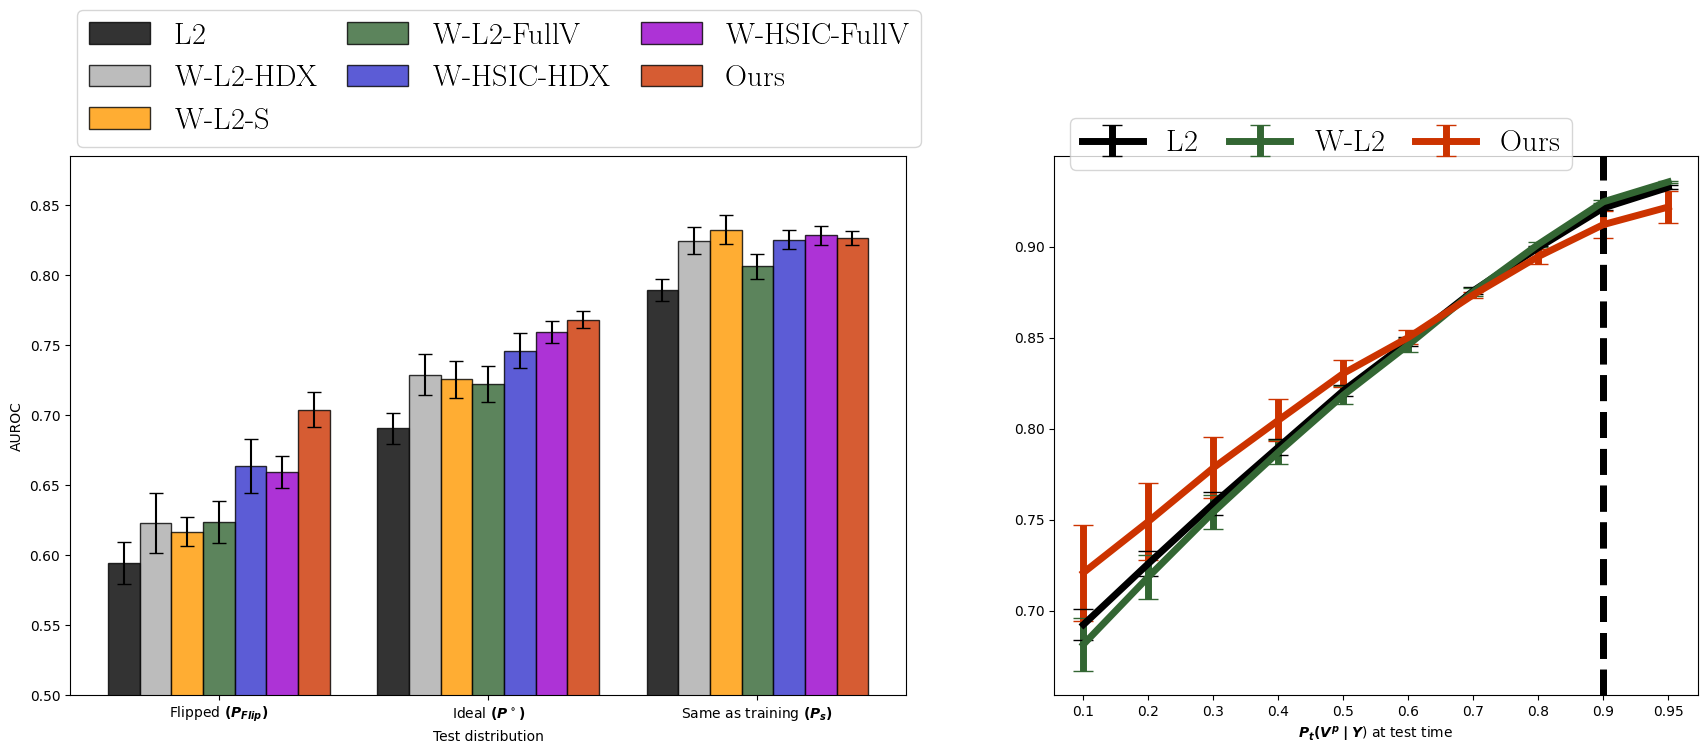

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(21, 7),  gridspec_kw={'width_ratios': [1.3, 1]})

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'extra bold'
matplotlib.rcParams['font.serif'] = 'Computer Modern Roman'
matplotlib.rcParams['axes.labelsize'] = 32
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams["legend.columnspacing"] = 1
matplotlib.rcParams["legend.fontsize"] = 22

        
# ---- waterbirds 
wb_col_lst = ['black', '#ABABAB', '#FF9900', '#336633', '#3333CC',  '#9900CC', '#CC3300'] 
generate_wb_plot(axes[0], wb_perf.values(), wb_col_lst, 'auc', 'mean')

# --- DR 
col_lst = ['black','#336633', '#CC3300'] 
generate_dr_plot(axes[1], dr_perf.values(), col_lst,  'micro_auc', 'mean')


# plt.tight_layout()
# savename = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/main_plot.pdf'
# plt.savefig(savename)
# cropped_savename = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/main_plot_cropped.pdf'
# crop(["-p", "5", savename, "-o", cropped_savename])


## Paper plot, waterbirds only (legend top)

(None, None, None)

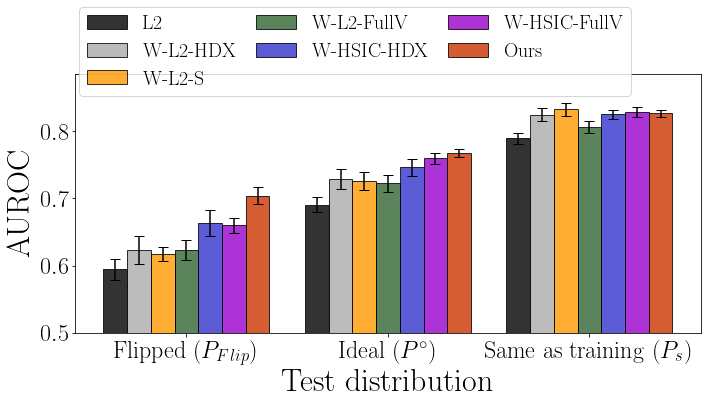

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'extra bold'
matplotlib.rcParams['font.serif'] = 'Computer Modern Roman'
matplotlib.rcParams['axes.labelsize'] = 32
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams["legend.columnspacing"] = 1
matplotlib.rcParams["legend.fontsize"] = 20

        
# ---- waterbirds 
wb_col_lst = ['black', '#ABABAB', '#FF9900', '#336633', '#3333CC',  '#9900CC', '#CC3300'] 
generate_wb_plot(axes, wb_perf.values(), wb_col_lst, 'auc', 'mean', False)
plt.tight_layout()
savename = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/wb_plot.pdf'
plt.savefig(savename)
cropped_savename = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/wb_plot_cropped.pdf'
crop(["-p", "5", savename, "-o", cropped_savename])


## Paper table, diabetic retinopathy

In [4]:
df_table = pd.concat([val for val in dr_perf.values()], axis=0)
df_table = df_table[['model', 'dist', 'micro_auc_mean', 'micro_auc_std']]
df_table = df_table[((df_table.dist==0.1) | (df_table.dist==0.5) | (df_table.dist==0.9))]
df_table['AUROC (STE)'] = df_table.micro_auc_mean.round(2).astype(str)+ \
    " (" + df_table.micro_auc_std.round(3).astype(str) + ") "

df_table.drop(['micro_auc_mean', 'micro_auc_std'], axis=1, inplace=True)
res_table = df_table.pivot(index='model', columns='dist', values='AUROC (STE)')
res_table = res_table.reindex(['L2', 'W-L2','Ours'])
res_table = res_table.reset_index()
res_table = res_table.rename(columns={0.1: 'Flipped', 0.5: 'Ideal $(P^\circ)$', 0.9: 'Same $(P_s)$'})
print(res_table.to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
model &       Flipped & Ideal $(P^\circ)$ &  Same $(P_s)$ \\
\midrule
   L2 & 0.69 (0.009)  &     0.82 (0.003)  & 0.92 (0.001)  \\
 W-L2 & 0.68 (0.015)  &     0.82 (0.005)  & 0.92 (0.001)  \\
 Ours & 0.72 (0.026)  &     0.83 (0.007)  & 0.91 (0.007)  \\
\bottomrule
\end{tabular}



## Show and tell table, broken down by group waterbirds

In [42]:
m_dnn_aucs, w_dnn_aucs = [], []

for rs in range(10):
    ours_pred = pd.read_csv(
        ('/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/'
         f'final_models/opt_pred_rs{rs}_unweighted_baseline_classic_'
         'pix128_bs64_vdim0.csv'))
    ours_pred = ours_pred[(ours_pred.dist==0.5)]
    
    land_auc = roc_auc_score(ours_pred.y0[ours_pred.y1==0], ours_pred.pred0[ours_pred.y1==0])
    water_auc = roc_auc_score(ours_pred.y0[(ours_pred.y1==1)], ours_pred.pred0[(ours_pred.y1==1)])
    
#     men_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==0)] == ours_pred.y0[(ours_pred.y1==0)])
#     women_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==1)] == ours_pred.y0[(ours_pred.y1==1)])

#     men_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==0], ours_pred.predictions0[ours_pred.y1==0])
#     women_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==1], ours_pred.predictions0[ours_pred.y1==1])    
    
    m_dnn_aucs.append(land_auc)
    w_dnn_aucs.append(water_auc)

In [53]:
print(f'{np.mean(m_dnn_aucs):.3f} ({np.std(m_dnn_aucs)/np.sqrt(10):.3f}), ' , 
    f'{np.mean(w_dnn_aucs):.3f} ({np.std(w_dnn_aucs)/np.sqrt(10):.3f})')

0.686 (0.013),  0.713 (0.015)


In [54]:
m_our_aucs, w_our_aucs = [], []

for rs in range(10):
    ours_pred = pd.read_csv(
        ('/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/'
         f'final_models/opt_pred_rs{rs}_weighted_hsic_two_step_'
         'pix128_bs64_vdim2.csv'))
    ours_pred = ours_pred[(ours_pred.dist==0.5)]
    
    land_auc = roc_auc_score(ours_pred.y0[ours_pred.y1==0], ours_pred.pred0[ours_pred.y1==0])
    water_auc = roc_auc_score(ours_pred.y0[(ours_pred.y1==1)], ours_pred.pred0[(ours_pred.y1==1)])
    
#     men_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==0)] == ours_pred.y0[(ours_pred.y1==0)])
#     women_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==1)] == ours_pred.y0[(ours_pred.y1==1)])

#     men_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==0], ours_pred.predictions0[ours_pred.y1==0])
#     women_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==1], ours_pred.predictions0[ours_pred.y1==1])    
    
    m_our_aucs.append(land_auc)
    w_our_aucs.append(water_auc)

In [55]:
print(f'{np.mean(m_our_aucs):.3f} ({np.std(m_our_aucs)/np.sqrt(10):.3f}), ' , 
    f'{np.mean(w_our_aucs):.3f} ({np.std(w_our_aucs)/np.sqrt(10):.3f})')

0.744 (0.012),  0.802 (0.009)


## Show and tell Diabetic retinopathy broken down by group

In [38]:
m_our_aucs, w_our_aucs = [], []

for rs in range(10):
    ours_pred = pd.read_csv(
        ('/nfs/turbo/coe-soto/mmakar/multiple_shortcut/dr/'
         f'final_models/opt_pred_rs{rs}_weighted_hsic_two_'
         'step_pix299_bs64_py1y00.9.csv'))
    ours_pred = ours_pred[(ours_pred.dist==0.5)]
    ours_pred['y0_d'] = np.where(ours_pred.y0==0, 1, 0)
    
    
    men_auc = roc_auc_score(ours_pred.y0[(ours_pred.y1==0)], ours_pred[
                [f'predictions{i}' for i in range(5)]][(ours_pred.y1==0)], 
                average='macro', multi_class='ovo')
    women_auc = roc_auc_score(ours_pred.y0[(ours_pred.y1==1)], ours_pred[
                [f'predictions{i}' for i in range(5)]][(ours_pred.y1==1)], 
                average='macro', multi_class='ovo')
    
#     men_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==0)] == ours_pred.y0[(ours_pred.y1==0)])
#     women_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==1)] == ours_pred.y0[(ours_pred.y1==1)])

#     men_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==0], ours_pred.predictions0[ours_pred.y1==0])
#     women_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==1], ours_pred.predictions0[ours_pred.y1==1])    
    
    m_our_aucs.append(men_auc)
    w_our_aucs.append(women_auc)

In [39]:
m_dnn_aucs, w_dnn_aucs = [], []

for rs in range(10):
    ours_pred = pd.read_csv(
        ('/nfs/turbo/coe-soto/mmakar/multiple_shortcut/dr/'
         f'final_models/opt_pred_rs{rs}_unweighted_baseline_'
         'classic_pix299_bs64_py1y00.9.csv'))
    ours_pred = ours_pred[(ours_pred.dist==0.5)]
    ours_pred['y0_d'] = np.where(ours_pred.y0==0, 1, 0)
    
    
    men_auc = roc_auc_score(ours_pred.y0[(ours_pred.y1==0)], ours_pred[
                [f'predictions{i}' for i in range(5)]][(ours_pred.y1==0)], 
                average='macro', multi_class='ovo')
    women_auc = roc_auc_score(ours_pred.y0[(ours_pred.y1==1)], ours_pred[
                [f'predictions{i}' for i in range(5)]][(ours_pred.y1==1)], 
                average='macro', multi_class='ovo')
    
 
#     men_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==0)] == ours_pred.y0[(ours_pred.y1==0)])
#     women_auc = np.mean(ours_pred.pred_class[(ours_pred.y1==1)] == ours_pred.y0[(ours_pred.y1==1)])
 
#     men_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==0], ours_pred.predictions0[ours_pred.y1==0])
#     women_auc = roc_auc_score(ours_pred.y0_d[ours_pred.y1==1], ours_pred.predictions0[ours_pred.y1==1]) 
    
    m_dnn_aucs.append(men_auc)
    w_dnn_aucs.append(women_auc)

In [40]:
np.mean(m_dnn_aucs), np.mean(w_dnn_aucs)

(0.5237948594284291, 0.5081776718364996)

In [41]:
np.mean(m_our_aucs), np.mean(w_our_aucs)

(0.5550784807651981, 0.5122194860014619)

## Waterbirds paper plot (legend side) 

(None, None, None)

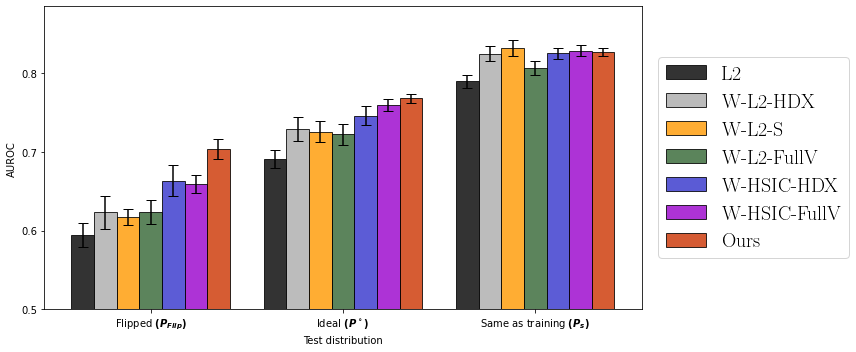

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'extra bold'
matplotlib.rcParams['font.serif'] = 'Computer Modern Roman'
matplotlib.rcParams['axes.labelsize'] = 32
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams["legend.columnspacing"] = 1
matplotlib.rcParams["legend.fontsize"] = 20

        
# ---- waterbirds 
wb_col_lst = ['black', '#ABABAB', '#FF9900', '#336633', '#3333CC',  '#9900CC', '#CC3300'] 
generate_wb_plot(axes, wb_perf.values(), wb_col_lst, 'auc', 'mean', True)
plt.tight_layout()
savename = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/wb_plot_side_leg.pdf'
plt.savefig(savename)
cropped_savename = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/wb_plot_side_leg_cropped.pdf'
crop(["-p", "5", savename, "-o", cropped_savename])


## Waterbirds show and tell 

DNN
All shortcuts
Ours


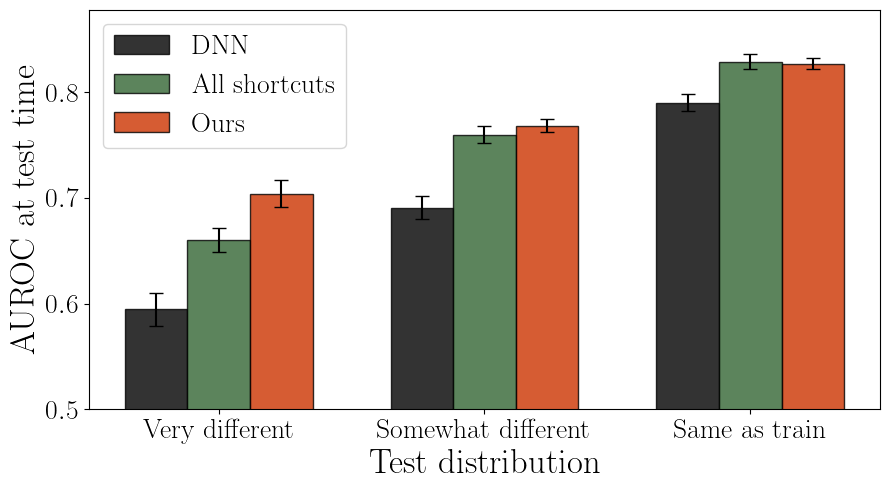

In [7]:
# set up data/plot 
wb_mini_perf = {
    'uw_l2': wb_perf['uw_l2'], 
    'w12_hsic': wb_perf['w12_hsic'], 
    'w2_hsic': wb_perf['w2_hsic']
}

wb_mini_perf['uw_l2'].Model = 'DNN'
wb_mini_perf['w12_hsic'].Model = 'All shortcuts'

wb_mini_perf = wb_mini_perf.values()

fig, ax = plt.subplots(1, 1, figsize=(9, 5))

metric = 'auc'
stat = 'mean'

# set up fonts 
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'extra bold'
matplotlib.rcParams['font.serif'] = 'Computer Modern Roman'
matplotlib.rcParams['axes.labelsize'] = 25
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams["legend.columnspacing"] = 1
matplotlib.rcParams["legend.fontsize"] = 20


# plot 
x_loc = [0, 0.85, 1.7]

width = 0.2
bar_width = 0.2

for df_i, df in enumerate(wb_mini_perf):
    print(df.Model.loc[0])
    if df.Model.loc[0] == 'All shortcuts':
        x_tick_loc = [i + width * df_i for i in x_loc]

    ax.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
                 width=bar_width, yerr= df[f'{metric}_std'], label=df.Model.loc[0], 
                 capsize= 5, edgecolor= 'black', 
                    color = col_lst[df_i], alpha =0.8)
ax.set_ylim(bottom=0.5)
ax.legend()
ax.set_ylabel("AUROC at test time")
ax.set_xlabel("Test distribution")
_ = ax.set_xticks(x_tick_loc)
_ = ax.set_xticklabels(['Very different', 'Somewhat different', 'Same as train'])
plt.tight_layout()
savename = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/wb_plot_talk.pdf'
plt.savefig(savename)



In [6]:
[key for key in wb_perf.keys()]

['uw_l2', 'w1_l2', 'w2_l2', 'w12_l2', 'w1_hsic', 'w12_hsic', 'w2_hsic']